In [1]:
import pandas as pd, numpy as np
import lightgbm as lgb

from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns

Nao existe uma metrica especificada no documento, <br>
Iremos utilizar do MAPE (Mean Absolute Percentage Error) <br>
<br>
Para mais informacoes sobre a mesma: https://en.wikipedia.org/wiki/Mean_absolute_percentage_error <br>

In [2]:
def mean_absolute_percentage_error(y_true, y_pred):
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    return np.mean(np.abs((y_true - y_pred) / y_true))

Podemos construir um unico modelo para o conjunto completo de dados, <br>
Mas por entender que se tratam de produtos completamente distintos, iremos fazer um modelo para cada tipo de vinho. <br>

In [3]:
rwhine = pd.read_csv('../data/input/red_whine.csv')
wwhine = pd.read_csv('../data/input/white_whine.csv')

rwhine.index = np.arange(len(rwhine))
wwhine.index = np.arange(len(wwhine))

Vamos dividir os dados em 3 conjuntos: <br><br>

Treino: 60% dados <br>
Validaçao: 20% dados <br>
Out Of Sample: 20% dados <br>
<br>
O conjunto de treino servira para o modelo aprender. <br>
O conjunto de validacao servira para avaliar o modelo durante seu aprendizado. <br>
O conjunto OOS servira para um score final, como dados nunca antes vistos pelo modelo. <br>
<br>
Estaremos utilizando um shuffle split. Um trabalho mais cuidadoso/correto seria nos assegurar de que todas essas distribuicoes sao representativas de um conjunto real de dados, uma vez que o shuffle split pode aleatoriamente segregar dados.

## modelagem

Para o modelo utilizaremos o que é considerado benchmark, a metodologia SGD, com a biblioteca da **Microsoft**, Lightgbm. <br>
Um trabalho mais completo compararia diferentes tipos de modelos, e tambem faria enseembles/stackings. <br>
Nao vemos a necessidade do mesmo nesse caso.

# Vinho Branco

In [4]:
data = wwhine

np.random.seed(42)

SS = ShuffleSplit(n_splits=1, test_size=0.4)

for train_index, test_index in SS.split(data.index.values):
    
    SS_2 = ShuffleSplit(n_splits=1, test_size=0.5)
    
    train_data = data.loc[train_index] 
    test_data = data.loc[test_index]
    
    test_data.index = np.arange(len(test_data))
    
    for validation_index, oos_index in SS_2.split(test_data.index.values):
        
        validation_data = test_data.loc[validation_index]
        oos_data = test_data.loc[oos_index]
        
X_train = train_data.drop('quality',1).values
y_train = train_data['quality'].values

X_valid = validation_data.drop('quality',1).values
y_valid = validation_data['quality'].values

X_OOS = oos_data.drop('quality',1).values
y_OOS = oos_data['quality'].values

evals_result = {}

gbm = lgb.LGBMRegressor(learning_rate=0.01, n_estimators=1500, objective='mape')

gbm.fit(X_train, y_train,
        eval_set=[(X_train, y_train),(X_valid, y_valid)],
        eval_metric='mape',
        feature_name=list(train_data.drop('quality',1).columns),
        early_stopping_rounds=50, verbose=100)

print ('\n')
print ('='*30)
print ('Out of Sample Score: {}'.format(mean_absolute_percentage_error(y_OOS, gbm.predict(X_OOS))))
print ('='*30)
print ('Out of Sample Rounded Predictions Score: {}'.format(mean_absolute_percentage_error(y_OOS, map(int,gbm.predict(X_OOS)))))
print ('='*30)

Training until validation scores don't improve for 50 rounds.
[100]	valid_0's mape: 0.0960492	valid_1's mape: 0.0957802
[200]	valid_0's mape: 0.0857217	valid_1's mape: 0.089528
[300]	valid_0's mape: 0.0799306	valid_1's mape: 0.0868803
[400]	valid_0's mape: 0.0771682	valid_1's mape: 0.0858827
[500]	valid_0's mape: 0.075534	valid_1's mape: 0.0853102
[600]	valid_0's mape: 0.0740492	valid_1's mape: 0.0849782
[700]	valid_0's mape: 0.0726592	valid_1's mape: 0.0848346
Early stopping, best iteration is:
[681]	valid_0's mape: 0.0728829	valid_1's mape: 0.0848255


Out of Sample Score: 0.0877079745829
Out of Sample Rounded Predictions Score: 0.0408163265306


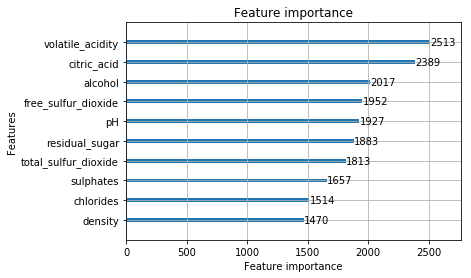

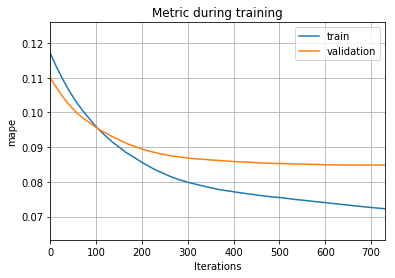

In [5]:
lgb.plot_importance(gbm, max_num_features=10)
lgb.plot_metric(gbm, metric='mape')
plt.legend(['train','validation'])

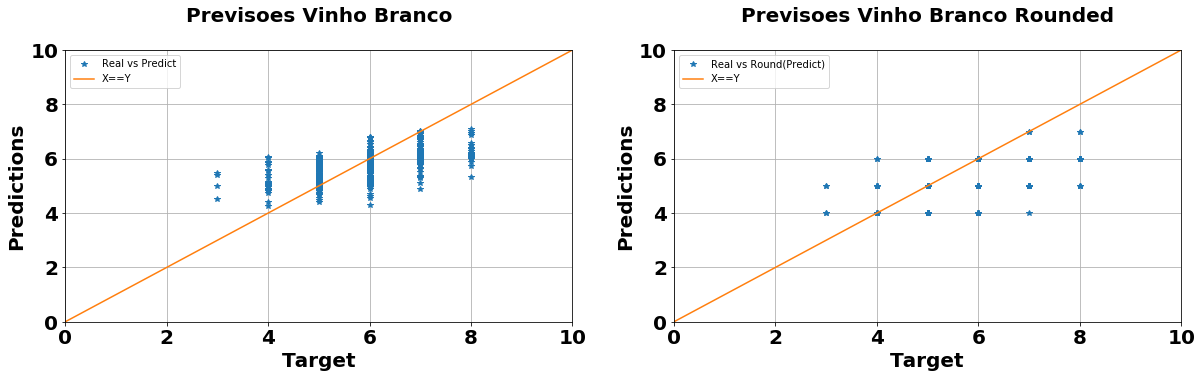

In [6]:
text_args = {'fontsize':20, 'fontweight':'bold'}

plt.figure(figsize=(20,5))

plt.subplot(121)

plt.plot(y_OOS, gbm.predict(X_OOS), '*')

plt.plot(np.arange(0,11),np.arange(0,11))

plt.legend(['Real vs Predict','X==Y'], fontsize=10)

plt.title('Previsoes Vinho Branco\n', **text_args)
plt.xticks(**text_args)
plt.yticks(**text_args)
plt.xlabel('Target',**text_args)
plt.ylabel('Predictions',**text_args)

plt.xlim(0,10)
plt.ylim(0,10)
plt.grid()

plt.subplot(122)

plt.plot(y_OOS, map(int,gbm.predict(X_OOS)), '*')

plt.plot(np.arange(0,11),np.arange(0,11))

plt.legend(['Real vs Round(Predict)','X==Y'], fontsize=10)

plt.title('Previsoes Vinho Branco Rounded\n', **text_args)
plt.xticks(**text_args)
plt.yticks(**text_args)
plt.xlabel('Target',**text_args)
plt.ylabel('Predictions',**text_args)

plt.xlim(0,10)
plt.ylim(0,10)
plt.grid()

# Vinho Tinto

In [7]:
data = rwhine

np.random.seed(42)

SS = ShuffleSplit(n_splits=1, test_size=0.4)

for train_index, test_index in SS.split(data.index.values):
    
    SS_2 = ShuffleSplit(n_splits=1, test_size=0.5)
    
    train_data = data.loc[train_index] 
    test_data = data.loc[test_index]
    
    test_data.index = np.arange(len(test_data))
    
    for validation_index, oos_index in SS_2.split(test_data.index.values):
        
        validation_data = test_data.loc[validation_index]
        oos_data = test_data.loc[oos_index]
        
X_train = train_data.drop('quality',1).values
y_train = train_data['quality'].values

X_valid = validation_data.drop('quality',1).values
y_valid = validation_data['quality'].values

X_OOS = oos_data.drop('quality',1).values
y_OOS = oos_data['quality'].values

evals_result = {}

gbm = lgb.LGBMRegressor(learning_rate=0.01, n_estimators=1500, objective='mape')

gbm.fit(X_train, y_train,
        eval_set=[(X_train, y_train),(X_valid, y_valid)],
        eval_metric='mape',
        feature_name=list(train_data.drop('quality',1).columns),
        early_stopping_rounds=50, verbose=100)

print ('\n')
print ('='*30)
print ('Out of Sample Score: {}'.format(mean_absolute_percentage_error(y_OOS, gbm.predict(X_OOS))))
print ('='*30)
print ('Out of Sample Rounded Predictions Score: {}'.format(mean_absolute_percentage_error(y_OOS, map(int,gbm.predict(X_OOS)))))
print ('='*30)

Training until validation scores don't improve for 50 rounds.
[100]	valid_0's mape: 0.0888634	valid_1's mape: 0.098337
[200]	valid_0's mape: 0.0752774	valid_1's mape: 0.0898008
[300]	valid_0's mape: 0.0696326	valid_1's mape: 0.0868248
[400]	valid_0's mape: 0.0660917	valid_1's mape: 0.0850375
[500]	valid_0's mape: 0.0616484	valid_1's mape: 0.0840858
[600]	valid_0's mape: 0.0589447	valid_1's mape: 0.0835608
[700]	valid_0's mape: 0.0573645	valid_1's mape: 0.0834441
[800]	valid_0's mape: 0.0563216	valid_1's mape: 0.0833704
[900]	valid_0's mape: 0.0553057	valid_1's mape: 0.083245
[1000]	valid_0's mape: 0.0543921	valid_1's mape: 0.083071
[1100]	valid_0's mape: 0.0536239	valid_1's mape: 0.0829875
Early stopping, best iteration is:
[1100]	valid_0's mape: 0.0536239	valid_1's mape: 0.0829875


Out of Sample Score: 0.080149475846
Out of Sample Rounded Predictions Score: 0.05


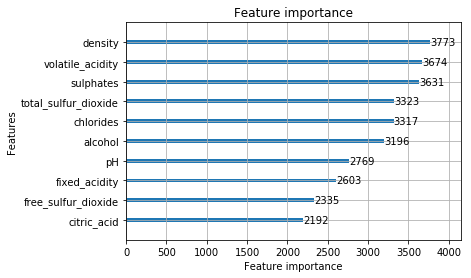

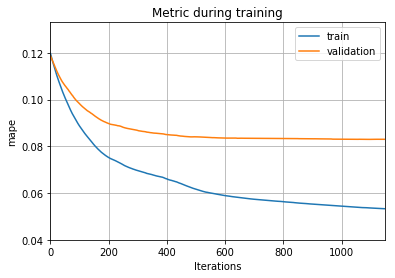

In [8]:
lgb.plot_importance(gbm, max_num_features=10)
lgb.plot_metric(gbm, metric='mape')
plt.legend(['train','validation'])

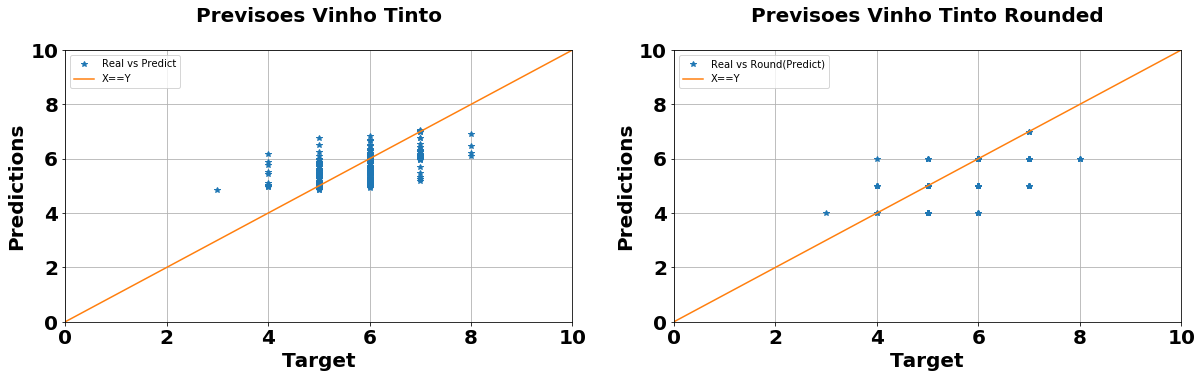

In [9]:
text_args = {'fontsize':20, 'fontweight':'bold'}

plt.figure(figsize=(20,5))

plt.subplot(121)

plt.plot(y_OOS, gbm.predict(X_OOS), '*')

plt.plot(np.arange(0,11),np.arange(0,11))

plt.legend(['Real vs Predict','X==Y'], fontsize=10)

plt.title('Previsoes Vinho Tinto\n', **text_args)
plt.xticks(**text_args)
plt.yticks(**text_args)
plt.xlabel('Target',**text_args)
plt.ylabel('Predictions',**text_args)

plt.xlim(0,10)
plt.ylim(0,10)
plt.grid()

plt.subplot(122)

plt.plot(y_OOS, map(int,gbm.predict(X_OOS)), '*')

plt.plot(np.arange(0,11),np.arange(0,11))

plt.legend(['Real vs Round(Predict)','X==Y'], fontsize=10)

plt.title('Previsoes Vinho Tinto Rounded\n', **text_args)
plt.xticks(**text_args)
plt.yticks(**text_args)
plt.xlabel('Target',**text_args)
plt.ylabel('Predictions',**text_args)

plt.xlim(0,10)
plt.ylim(0,10)
plt.grid()

## Conclusoes

Separar os modelos para vinhos distintos deve ser benefico. Dizemos isso porque podemos observar que o numero de estimadores antes do modelo começar a **overfitar** para os dados de validacao é bem distinto em ambos os casos (680 e 1100). <br>
<br>
A precisao dos modelos tambem varia consideravelmente entre os conjuntos de dados, tendo MAPE scores de 8.8% e 8.0%.<br>Para os casos arredondados a diferença relativa é ainda maior, de 4% para 5%<br>
Tambem se pode sustentar essa afirmacao, atraves dos valores distintos de peso para as variaveis, que cada modelo obtem. <br>
Num trabalho mais completo, fariamos um modelo com todos os dados, e com o tipo de vinho como variavel categorica binarizada. Poderiamos assim conclusivamente afirmar o mesmo. <br>

<br>
Uma modelagem mais cuidadosa testaria diferentes tipos de modelos, stacking e enseemble, buscando otimizar os resultados. <br>
Poderiamos tambem analisar para quais tipos de dados nosso modelo performa melhor/pior. Fizemos graficos comparando os valores OOS e as predições dos modelos, porem nao fomos a fundo no assunto. <br>
<br>
Para mais informações, duvidas e/ou sugestoes: eloi@pattaro.com.br